In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy import *
from scipy.linalg import expm
from matplotlib.patches import ConnectionPatch
import matplotlib.patches as mpatches
from brokenaxes import brokenaxes
from scipy import stats

In [2]:
# Range of time (unit: year)
t = arange(0, 650, 1)
time = arange(2000, 2000 + len(t))
# Range of age (unit: year)
age = arange(1, 1001)
# Concentration of CO2
X_at = [1715 * exp(0.0305 * ti) / (1715 + exp(0.0305 * ti) - 1) + 284 for ti in t]
# Global annual mean temperature
sigma = 4.5
Ts = [15 + (sigma / log(2)) * log(Xa / 285)
      for Xa in X_at]

############# Input #############
x = 0.65
Gamma_Ts = [42.7 + 1.68 * (T - 25) + 0.012 * (T - 25) ** 2 for T in Ts]
Beta_X_Ts = [(3 * x * Xa * Gamma) / ((x * Xa - Gamma) * (x * Xa + 2 * Gamma)) for Xa, Gamma in zip(X_at, Gamma_Ts)]
s0 = 300 # Input at initial time
# Input
S1 = [s0 * (1 + 2.14 * Beta * log(Xa / 285)) for Beta, Xa in zip(Beta_X_Ts, X_at)]
# Temperature scale
Var = [2 ** (0.1 * new - 1.5) for new in Ts]

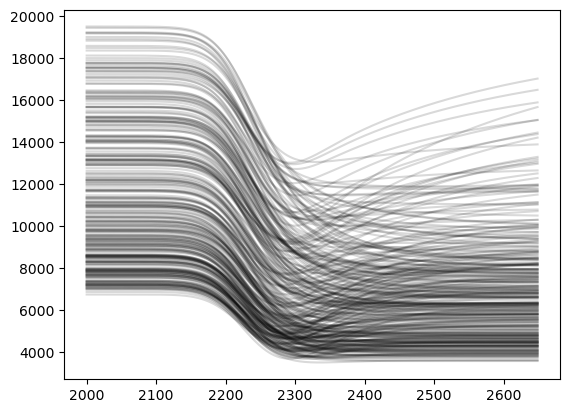

In [28]:
########
# Nonlinear microbial model with inverse Michaelis-Menten kinetics
########
cue = linspace(0.2, 0.6, 100) # Carbon use efficiency
v_s_rMM = linspace(0.02, 0.06, 100) # Maximum uptake rate of soil carbon pool in rMM
u_b = linspace(0.1, 0.9, 100) # turnover rate
k = 0.1
K_b = 100
# Maximum uptake rate of litter carbon pool in rMM
list_v_l_rMM = [0.84 * exp(0.063 * (T - 15)) for T in Ts]
number = 1000

list_P_a_rMM_first = [] # Mean age at steady state in rMM
list_P_a_rMM_last = [] # Mean age in the last year in rMM
list_P_a_rMM_l_first = [] # Mean age at steady state in rMM
list_P_a_rMM_l_last = [] # Mean age in the last year in rMM
list_P_a_rMM_s_first = [] # Mean age at steady state in rMM
list_P_a_rMM_s_last = [] # Mean age in the last year in rMM
list_P_a_rMM_b_first = [] # Mean age at steady state in rMM
list_P_a_rMM_b_last = [] # Mean age in the last year in rMM

list_CUE_rMM = []
list_V_S_rMM = []
list_U_B_rMM = []
arr_rMM = array([[]] * 653)
arr_rMM_l = array([[]] * 653)
arr_rMM_b = array([[]] * 653)

arr_rMM_3d = empty(shape=(1, 650, 1000))
arr_rMM_3d_l = empty(shape=(1, 650, 1000))
arr_rMM_3d_s = empty(shape=(1, 650, 1000))
arr_rMM_3d_b = empty(shape=(1, 650, 1000))

plt.figure()
while number >= 1:
    CUE = random.choice(cue)
#     CUE = mean(list_cue_rMM)
    V_S_rMM = random.choice(v_s_rMM)
#     V_S_rMM = mean(list_vs_rMM)
    U_B = random.choice(u_b)
#     U_B = mean(list_ub_rMM)
    list_cue = [CUE - 0.032 * (T - 15) for T in Ts]
    if min(list_cue) > 0: # Carbon use efficiency is positive
        list_v_s_rMM = [V_S_rMM * exp(0.02 * (T - 15)) for T in Ts]
        list_u_b = [U_B]
        # Carbon content at steady state
        C_l_ini_rMM = ((1 - k) * S1[0]) / list_v_l_rMM[0] + ((list_cue[0] ** (-1) - 1) * (1 - k) * list_u_b[0] * K_b) / \
                      list_v_l_rMM[0]
        C_b_ini_rMM = S1[0] / ((list_cue[0] ** (-1) - 1) * list_u_b[0])
        C_s_ini_rMM = (k + 1 / (list_cue[0] ** (-1) - 1)) * S1[0] / list_v_s_rMM[0] + (1 + k * (list_cue[0] ** (-1) - 1)) * \
                      list_u_b[0] * K_b / list_v_s_rMM[0]
        if 6000 < C_s_ini_rMM < 20000:
            list_C_l_rMM = [] # Litter carbon content
            list_C_s_rMM = [] # Soil carbon content
            list_C_b_rMM = [] # Microbial biomass carbon content
            for e, us, ul, S in zip(list_cue, list_v_s_rMM, list_v_l_rMM, S1):
                uptake_ul = ul * C_b_ini_rMM / (C_b_ini_rMM + K_b)
                uptake_us = us * C_b_ini_rMM / (C_b_ini_rMM + K_b)
                if uptake_ul < 1 and uptake_us < 1:
                    del_C_l_rMM = -ul * C_b_ini_rMM / (C_b_ini_rMM + K_b) * C_l_ini_rMM + (1 - k) * S
                    del_C_s_rMM = -us * C_b_ini_rMM / (C_b_ini_rMM + K_b) * C_s_ini_rMM + U_B * C_b_ini_rMM + k * S
                    del_C_b_rMM = e * ul * C_b_ini_rMM / (C_b_ini_rMM + K_b) * C_l_ini_rMM + e * us * C_b_ini_rMM / (
                            C_b_ini_rMM + K_b) * C_s_ini_rMM - U_B * C_b_ini_rMM
                    C_l_ini_rMM = C_l_ini_rMM + del_C_l_rMM
                    C_s_ini_rMM = C_s_ini_rMM + del_C_s_rMM
                    C_b_ini_rMM = C_b_ini_rMM + del_C_b_rMM
                    list_C_l_rMM.append(C_l_ini_rMM)
                    list_C_s_rMM.append(C_s_ini_rMM)
                    list_C_b_rMM.append(C_b_ini_rMM)
            if len(list_C_s_rMM) == 650:
                if  list_C_s_rMM[649] - list_C_s_rMM[0] < 0:

#                     plt.plot(arange(2000, 2650), list_C_s_rMM, color='black', alpha=0.15)
                    arr_tem = array(list_C_s_rMM)
                    arr_tem2 = insert(arr_tem, 0, [CUE, V_S_rMM, U_B])
                    arr_rMM = column_stack((arr_rMM, arr_tem2))
                    
                    arr_tem_l = array(list_C_l_rMM)
                    arr_tem2_l = insert(arr_tem_l, 0, [CUE, V_S_rMM, U_B])
                    arr_rMM_l = column_stack((arr_rMM_l, arr_tem2_l))
                    
                    arr_tem_b = array(list_C_b_rMM)
                    arr_tem2_b = insert(arr_tem_b, 0, [CUE, V_S_rMM, U_B])
                    arr_rMM_b = column_stack((arr_rMM_b, arr_tem2_b))
                    
                    plt.plot(arange(2000, 2650), [x + y + z for x, y, z in zip(list_C_l_rMM, list_C_s_rMM, list_C_b_rMM)], color='black', alpha=0.15)
                    
                    list_CUE_rMM.append(CUE)
                    list_V_S_rMM.append(V_S_rMM)
                    list_U_B_rMM.append(U_B)

#                     number = number - 1
#     continue
# arr_rMM_mean_Cs = average(arr_rMM.T, axis=0)
# arr_rMM_mean_Cl = average(arr_rMM_l.T, axis=0)
# arr_rMM_mean_Cb = average(arr_rMM_b.T, axis=0)
# plt.plot(arange(2000, 2650), arr_rMM_mean_Cs[3:], c='r')
# all_pool_carbon = arr_rMM_mean_Cs + arr_rMM_mean_Cl + arr_rMM_mean_Cb
# plt.plot(arange(2000, 2650), all_pool_carbon[3:], c='r')
# plt.plot(arange(2000, 2650), arr_rMM_mean_Cl[3:], c='b')
# plt.plot(arange(2000, 2650), arr_rMM_mean_Cb[3:], c='green')

# arr_rMM = arr_rMM.T
# save('E://论文//模型//Wang//np_file//20220515//arr_rMM_Cs_all', arr_rMM)

                    ######################################## Compute age distribution
                    # Carbon content at steady state
                    C_s_rMM = (k + 1 / (list_cue[0] ** (-1) - 1)) * S1[0] / list_v_s_rMM[0] + (
                                1 + k * (list_cue[0] ** (-1) - 1)) * list_u_b[0] * K_b / list_v_s_rMM[0]
                    C_b_rMM = S1[0] / (list_cue[0] ** (-1) - 1 * list_u_b[0])
                    C_l_rMM = (1 - k) * S1[0] / list_v_l_rMM[0] + (list_cue[0] ** (-1) - 1) * (1 - k) * list_u_b[0] * K_b / \
                              list_v_l_rMM[0]
                    # Transition matrix at steady state
                    B0_rMM = mat([
                        [-list_v_l_rMM[0] * C_b_rMM / (C_b_rMM + K_b), 0, 0],
                        [0, -list_v_s_rMM[0] * C_b_rMM / (C_b_rMM + K_b), list_u_b[0]],
                        [list_cue[0] * list_v_l_rMM[0] * C_b_rMM / (C_b_rMM + K_b),
                         list_cue[0] * list_v_s_rMM[0] * C_b_rMM / (C_b_rMM + K_b), -list_u_b[0]]])
                    # Input at steady state
                    U_t = mat([
                        [(1 - k) * S1[0]],
                        [k * S1[0]],
                        [0]])
                    # Age mass distribution at steady state
                    p0_rMM = [expm(age1 * B0_rMM) * U_t for age1 in age]

                    
                    soc_l_rMM_dataframe = pd.DataFrame(columns=['year', 'soc_l_A'])
                    Input_l_rMM = [(1 - k) * S for S in S1]
                    pa_pre_rMM = p0_rMM.copy()
                    pa_pre_rMM = hstack(pa_pre_rMM)
                    pa_pre1000_l_rMM = list(array(pa_pre_rMM[0, :len(age)]).reshape(len(age), ))
                    ##########################################################################
                    soc_s_rMM_dataframe = pd.DataFrame(columns=['year', 'soc_s_A'])
                    Input_s_rMM = [(k) * S for S in S1]
                    pa_pre1000_s_rMM = list(array(pa_pre_rMM[1, :len(age)]).reshape(len(age), ))
                    ##########################################################################
                    soc_b_rMM_dataframe = pd.DataFrame(columns=['year', 'soc_b_A'])
                    Input_b_rMM = [0]
                    pa_pre1000_b_rMM = list(array(pa_pre_rMM[2, :len(age)]).reshape(len(age), ))
                    ##########################################################################
                    age_density_l_rMM = []
                    age_density_s_rMM = []
                    age_density_b_rMM = []
                    for yr in arange(650):
                        # input
                        pa_pre1000_l_rMM = [Input_l_rMM[yr]] + list(
                            array(pa_pre1000_l_rMM[:len(age)]).reshape(len(age), ))  # 1001
                        pa_pre1000_s_rMM = [Input_s_rMM[yr]] + list(
                            array(pa_pre1000_s_rMM[:len(age)]).reshape(len(age), ))  # 1001
    
                        soc_l_rMM_dataframe.loc[len(soc_l_rMM_dataframe)] = [yr + 2000, sum(pa_pre1000_l_rMM[:len(age)])]
                        soc_s_rMM_dataframe.loc[len(soc_s_rMM_dataframe)] = [yr + 2000, sum(pa_pre1000_s_rMM[:len(age)])]
                        soc_b_rMM_dataframe.loc[len(soc_b_rMM_dataframe)] = [yr + 2000, sum(pa_pre1000_b_rMM[:len(age)])]
    
                        # microbial uptake of litter, soil
                        Uptake_l_rMM = [list_v_l_rMM[yr] * pa_pre1000_l_rMM[i] * sum(pa_pre1000_b_rMM) / (sum(pa_pre1000_b_rMM) + K_b)
                                        for i in
                                        arange(len(age) + 1)]
                        Uptake_s_rMM = [list_v_s_rMM[yr] * pa_pre1000_s_rMM[i] * sum(pa_pre1000_b_rMM) / (sum(pa_pre1000_b_rMM) + K_b)
                                        for i in
                                        arange(len(age) + 1)]
                        # Uptake_l = insert(array(Uptake_l_),0,0)
                        # Uptake_s = insert(array(Uptake_s_),0,0)
                        # microbial decay
                        decay_mic_rMM = list_u_b[0] * array(pa_pre1000_b_rMM)  # age: 2-1001
                        #    decay_mic = insert(decay_mic1,0,[0,0]) # age [0,1001]
                        pa_present_l_rMM = array(pa_pre1000_l_rMM) - array(Uptake_l_rMM)  # age: 1-1001
                        pa_pre1000_l_rMM = pa_present_l_rMM[:len(age)].copy().tolist()
                        age_density_l_rMM = age_density_l_rMM + pa_pre1000_l_rMM
    
                        pa_present_s_rMM = array(pa_pre1000_s_rMM) - array(Uptake_s_rMM) + insert(decay_mic_rMM, 0,
                                                                                                  0)  # age: 1-1001
                        pa_pre1000_s_rMM = pa_present_s_rMM[:len(age)].copy().tolist()
                        age_density_s_rMM = age_density_s_rMM + pa_pre1000_s_rMM
    
                        pa_present_b_rMM = insert((pa_pre1000_b_rMM - decay_mic_rMM), 0, 0) + list_cue[yr] * array(Uptake_l_rMM) + \
                                           list_cue[yr] * array(
                            Uptake_s_rMM)
                        pa_pre1000_b_rMM = pa_present_b_rMM[:len(age)].copy().tolist()
                        age_density_b_rMM = age_density_b_rMM + pa_pre1000_b_rMM
    
                    age_density_l_rMM = array(age_density_l_rMM).reshape(len(time), len(age))
                    age_density_s_rMM = array(age_density_s_rMM).reshape(len(time), len(age))
                    age_density_b_rMM = array(age_density_b_rMM).reshape(len(time), len(age))
                    
                    age_density_rMM = age_density_l_rMM + age_density_s_rMM + age_density_b_rMM
                    
                    age_density_carbon_rMM = age_density_rMM / age_density_rMM.sum(axis=1)[:, None]
    
                    pa_first = []
                    for i in range(1, 1001):
                        pa_tem = i * age_density_carbon_rMM[0, i - 1]
                        pa_first.append(pa_tem)
                    mean_tem = sum(pa_first)
                    pa_last = []
                    for i in range(1, 1001):
                        pa_tem2 = i * age_density_carbon_rMM[649, i - 1]
                        pa_last.append(pa_tem2)
                    mean_tem2 = sum(pa_last)
    
                    list_P_a_rMM_first.append(mean_tem)
                    list_P_a_rMM_last.append(mean_tem2)
            
                    ###### litter
                    age_density_l_carbon_rMM = age_density_l_rMM / age_density_l_rMM.sum(axis=1)[:, None]
    
                    pa_first = []
                    for i in range(1, 1001):
                        pa_tem = i * age_density_l_carbon_rMM[0, i - 1]
                        pa_first.append(pa_tem)
                    mean_tem = sum(pa_first)
                    pa_last = []
                    for i in range(1, 1001):
                        pa_tem2 = i * age_density_l_carbon_rMM[649, i - 1]
                        pa_last.append(pa_tem2)
                    mean_tem2 = sum(pa_last)
    
                    list_P_a_rMM_l_first.append(mean_tem)
                    list_P_a_rMM_l_last.append(mean_tem2)

                    ###### soil
                    age_density_s_carbon_rMM = age_density_s_rMM / age_density_s_rMM.sum(axis=1)[:, None]
    
                    pa_first = []
                    for i in range(1, 1001):
                        pa_tem = i * age_density_s_carbon_rMM[0, i - 1]
                        pa_first.append(pa_tem)
                    mean_tem = sum(pa_first)
                    pa_last = []
                    for i in range(1, 1001):
                        pa_tem2 = i * age_density_s_carbon_rMM[649, i - 1]
                        pa_last.append(pa_tem2)
                    mean_tem2 = sum(pa_last)
    
                    list_P_a_rMM_s_first.append(mean_tem)
                    list_P_a_rMM_s_last.append(mean_tem2)

                    ###### microbe
                    age_density_b_carbon_rMM = age_density_b_rMM / age_density_b_rMM.sum(axis=1)[:, None]
    
                    pa_first = []
                    for i in range(1, 1001):
                        pa_tem = i * age_density_b_carbon_rMM[0, i - 1]
                        pa_first.append(pa_tem)
                    mean_tem = sum(pa_first)
                    pa_last = []
                    for i in range(1, 1001):
                        pa_tem2 = i * age_density_b_carbon_rMM[649, i - 1]
                        pa_last.append(pa_tem2)
                    mean_tem2 = sum(pa_last)
    
                    list_P_a_rMM_b_first.append(mean_tem)
                    list_P_a_rMM_b_last.append(mean_tem2)

                    age_density_carbon_A_tem = age_density_carbon_rMM[newaxis, :]
                    arr_rMM_3d = vstack((arr_rMM_3d, age_density_carbon_A_tem))

                    age_density_carbon_A_tem_l = age_density_l_carbon_rMM[newaxis, :]
                    arr_rMM_3d_l = vstack((arr_rMM_3d_l, age_density_carbon_A_tem_l))
                    
                    age_density_carbon_A_tem_s = age_density_s_carbon_rMM[newaxis, :]
                    arr_rMM_3d_s = vstack((arr_rMM_3d_s, age_density_carbon_A_tem_s))
                    
                    age_density_carbon_A_tem_b = age_density_b_carbon_rMM[newaxis, :]
                    arr_rMM_3d_b = vstack((arr_rMM_3d_b, age_density_carbon_A_tem_b))
                    
                    number = number - 1
    continue

arr_rMM = arr_rMM.T
arr_rMM_l = arr_rMM_l.T
arr_rMM_b = arr_rMM_b.T
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_Cs_1000', arr_rMM)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_Cl_1000', arr_rMM_l)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_Cb_1000', arr_rMM_b)

arr_rMM_3d = delete(arr_rMM_3d, 0, axis=0)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_3d_1000', arr_rMM_3d)
arr_rMM_3d_l = delete(arr_rMM_3d_l, 0, axis=0)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_3d_l_1000', arr_rMM_3d_l)
arr_rMM_3d_s = delete(arr_rMM_3d_s, 0, axis=0)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_3d_s_1000', arr_rMM_3d_s)
arr_rMM_3d_b = delete(arr_rMM_3d_b, 0, axis=0)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_3d_b_1000', arr_rMM_3d_b)


list_P_a_rMM_first = array(list_P_a_rMM_first)
list_P_a_rMM_last = array(list_P_a_rMM_last)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_ma_f_1000', list_P_a_rMM_first)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_ma_l_1000', list_P_a_rMM_last)

list_P_a_rMM_l_first = array(list_P_a_rMM_l_first)
list_P_a_rMM_l_last = array(list_P_a_rMM_l_last)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_l_ma_f_1000', list_P_a_rMM_l_first)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_l_ma_l_1000', list_P_a_rMM_l_last)

list_P_a_rMM_s_first = array(list_P_a_rMM_s_first)
list_P_a_rMM_s_last = array(list_P_a_rMM_s_last)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_s_ma_f_1000', list_P_a_rMM_s_first)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_s_ma_l_1000', list_P_a_rMM_s_last)

list_P_a_rMM_b_first = array(list_P_a_rMM_b_first)
list_P_a_rMM_b_last = array(list_P_a_rMM_b_last)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_b_ma_f_1000', list_P_a_rMM_b_first)
save('/Users/lifu/Downloads/age_paper_plot/arr_rMM_b_ma_l_1000', list_P_a_rMM_b_last)


save('/Users/lifu/Downloads/age_paper_plot/list_CUE_rMM', list_CUE_rMM)
save('/Users/lifu/Downloads/age_paper_plot/list_V_S_rMM', list_V_S_rMM)
save('/Users/lifu/Downloads/age_paper_plot/list_U_B_rMM', list_U_B_rMM)
